In [1]:
# We're going to explore mdtraj, an excellent library for working with molecular dynamics trajectories which also
# forms the backend for other analysis tools, like PyEMMA
import mdtraj as md

# We'll work with four molecular dynamics trajectories, run using Amber, started from the same T4 clamp structure
# (initial model in clamp_init.pdb). For the sake of size, they've been subsampled to just 10 frames each.
# They are in netcdf format, which contains no topology information, so we'll also have to supply mdtraj with the
# corresponding parameter/topology file. Let's load the 4 trajectories into a list:
trajlist = [md.load("demo_" + str(i) + ".nc", top = "clamp.prmtop") for i in range(4)]

# Note: mdtraj.load() can also read a list of back-to-back trajectories into a single trajectory, and even
# recognize and discard overlapping frames. It can also read in only n-th frame, or an arbitrary subset of atoms.

# Note: mdtraj.load() reads the trajectory into memory when it is called. mdtraj.iterload() and mdtraj.open()
# allow analysis on single frames or chunks of frames at a time without loading the entire trajectory into memory,
# and 

# And let's look at the times our frames correspond to (note mdtraj uses units of picoseconds and nanometers):
print(trajlist[0].time)

[ 11010. 111010. 211010. 311010. 411010. 511010. 611010. 711010. 811010.
 911010.]


In [2]:
# We now have a list of Trajectory objects, which have been unwrapped such that our clamps are whole using cpptraj:

# parm clamp.prmtop
# trajin ../0/run_npt_0.nc
# reference clamp_init.pdb
# unwrap reference :1-684
# trajout demo_0.nc offset 10000
# run

# There is also a python interface to cpptraj, pytraj

# Note that we could also have imaged in mdtraj, but this is unreliable for heavily-subsampled trajectories like
# our example today:
# trajlist = [traj.image_molecules(anchor_molecules = (traj.topology.find_molecules()[:3])) for traj in trajlist]
# or relying on mdtraj to identify relevant molecules:
# trajlist = [traj.image_molecules() for traj in trajlist]

# We won't be doing any analysis with solvent atoms, so let's remove them:
trajlist = [traj.remove_solvent() for traj in trajlist]

# Let's align to the initial model. We'll first load in this reference:
reference = md.load("clamp_init.pdb").remove_solvent()

# Now we'll superpose on the reference. By default, mdtraj will do this in parallel:
trajlist = [traj.superpose(reference) for traj in trajlist]

In [3]:
# We could write out these four trajectories for viewing in PyMOL or another viewer:
for i, traj in enumerate(trajlist):
    traj.save("aligned_" + str(i) + ".pdb")

# But instead let's look at a trajectory within this notebook using an embedded NGL viewer:
import nglview as nv

# Note: nglview can handle enormous trajectories when paired with mdtraj without keeping the trajectory in memory

view = nv.show_mdtraj(trajlist[0])
view

# Note: you may have to enable the nglview widget using:
# jupyter nbextension enable nglview --py --sys-prefix
# or even:
# jupyter nbextension install widgetsnbextension --py --sys-prefix
# jupyter nbextension enable widgetsnbextension --py --sys-prefix

_ColormakerRegistry()

NGLWidget(max_frame=9)

In [4]:
# We see that the first trajectory has closed over the course of this trajectory. The others remain in 'open'
# conformations. Let's try to visualize how these four trajectories are evolving by their RMSD to the open
# structure (3u60) and the closed crystal structure (1czd)

# Let's load in 1czd. I've downloaded it in PDB format (1czd.pdb):
reference_1czd = md.load("1czd_init.pdb").remove_solvent()

# For each trajectory, we want to calculate the RMSD to both 3u60 and 1czd for each frame using md.rmsd(), which
# will return a NumPy array of RMSDs, calculated in parallel by default:
rmsd_3u60 = [md.rmsd(traj, reference) for traj in trajlist]
rmsd_1czd = [md.rmsd(traj, reference_1czd) for traj in trajlist]

# We could also select only heavy atoms using the topology object from the first trajectory, since we know they
# all share the same topology:
heavy_selection = trajlist[0].topology.select_atom_indices('heavy')
#all_selection = reference_1czd.topology.select_atom_indices('all')
rmsd_3u60_heavy = [md.rmsd(traj, reference, atom_indices = heavy_selection) for traj in trajlist]
rmsd_1czd_heavy = [md.rmsd(traj, reference_1czd, atom_indices = heavy_selection) for traj in trajlist]

Text(0, 0.5, 'trajectory time (ns)')

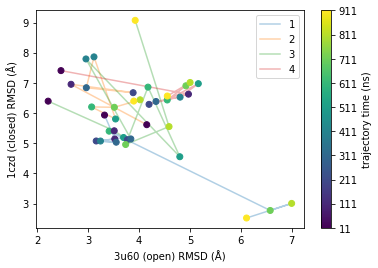

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

# Let's visualize each trajectory's RMSD to each reference over time:
for i in range(4):
    # Draw lines connecting consecutive frames in a trajectory:
    plt.plot(rmsd_3u60_heavy[i] * 10, rmsd_1czd_heavy[i] * 10, alpha = 0.35, zorder = 1)
    # Draw points at each frame, colored by their frame number, and making sure they appear on top of the lines:
    plt.scatter(rmsd_3u60_heavy[i] * 10, rmsd_1czd_heavy[i] * 10, c = np.arange(rmsd_3u60[i].shape[0]), zorder = 2)

plt.xlabel("3u60 (open) RMSD (Å)")
plt.ylabel("1czd (closed) RMSD (Å)")
plt.legend(np.arange(4) + 1)
cbar = plt.colorbar()
# Convert frame index to time on the colorbar:
cbar.ax.set_yticklabels((trajlist[0].time / 1000).astype(int)) # quick hack to round, in general use str formatting
cbar.ax.set_ylabel("trajectory time (ns)")

# We see, as before, that trajectory 1 closes into a structure which is like 1czd and not 3u60 in the last 3 frames

In [6]:
# Now let's calculate the correlation between residues' center-of-mass displacements. We'll start by calculating
# the center of mass for each residue in each frame, for each trajectory:
comxyzlist = [np.empty((traj.n_frames, traj.n_residues, 3)) for traj in trajlist]

for i, traj in enumerate(trajlist):
    for j, fares in enumerate(traj.topology.residues): # iterate over residues in the topology
        # Take the weighted average of x,y,z for each frame over the atoms in this residue
        comxyzlist[i][:,j,:] = np.average(traj.xyz[:,[atom.index for atom in fares.atoms],:],
                                   weights = [atom.element.mass for atom in fares.atoms],
                                   axis = 1)


comcorr = [np.empty((traj.n_residues, traj.n_residues)) for traj in trajlist]

for k, comxyz in enumerate(comxyzlist):
    for i in range(comxyz.shape[1]):
        # Iterate over the lower triangle of the correlation matrix, including the diagonal, since we know it is
        # symmetric:
        for j in range(i + 1):
            # Calculate the mean x,y,z for residue i and j over all frames, then subtract it from each frame:
            meani = np.mean(comxyz[:,i,:], axis = 0)
            meanj = np.mean(comxyz[:,j,:], axis = 0)
            displacementi = comxyz[:,i,:] - meani
            displacementj = comxyz[:,j,:] - meanj
            # Dot the displacement vector of i and j for each frame, then take the average of this dot product over
            # all frames:
            dotmean = np.mean(np.sum((displacementi) * (displacementj), axis = 1))
            # Calculate the denominator, that is the mean norm of each displacement vector:
            normi = np.mean(np.linalg.norm(displacementi, axis = 1))
            normj = np.mean(np.linalg.norm(displacementj, axis = 1))
            comcorr[k][i,j] = dotmean / (normi * normj)
            comcorr[k][j,i] = comcorr[k][i,j]

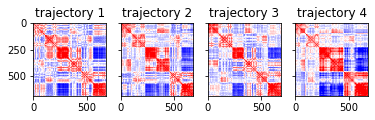

In [7]:
# Now we'll plot all 4 correlation matrices in a single plot:
f, axes = plt.subplots(1, len(trajlist), sharey = True)
for i in range(len(trajlist)):
    axes[i].imshow(comcorr[i], vmin = -1, vmax = 1, cmap = 'bwr')
    axes[i].set_title("trajectory " + str(i + 1))

Text(0, 0.5, 'Difference in residue SASA (square nm)')

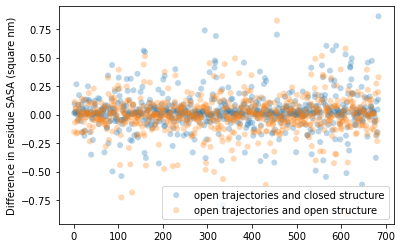

In [8]:
# We could compare the solvent-accessible surface area per residue over the 3 trajectories that stay open to the
# closed state

sasatraj = [md.shrake_rupley(traj, mode = 'residue') for traj in trajlist[1:]]
sasa1czd = md.shrake_rupley(reference_1czd, mode = 'residue')
sasa3u60 = md.shrake_rupley(reference, mode = 'residue')

plt.scatter(np.arange(trajlist[0].topology.n_residues) + 1, np.mean(sasatraj,axis = (0,1)) - sasa1czd[0],
            alpha = 0.3, edgecolors = 'none')
plt.scatter(np.arange(trajlist[0].topology.n_residues) + 1, np.mean(sasatraj, axis = (0,1)) - sasa3u60[0],
            alpha = 0.3, edgecolors = 'none')

plt.legend(["open trajectories and closed structure", "open trajectories and open structure"])
plt.ylabel("Difference in residue SASA (square nm)")

# This isn't very helpful as-is, because different residues have different SASAs even when they are fully
# solvent-exposed. What we'd really like to compute is the change in relative SASA

Text(0, 0.5, 'Difference in relative SASA')

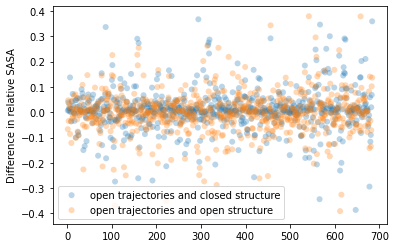

In [9]:
# We'll use the SASA normalization (maximum values) from https://doi.org/10.1371/journal.pone.0080635
# Make a dictionary to convert 1-letter amino acid codes to maximum SASA:
max_sasa = {'A': 129.0, 'R': 274.0, 'N': 195.0, 'D': 193.0, 'C': 167.0, 'E': 223.0, 'Q': 225.0, 'G': 104.0,
            'H': 224.0, 'I': 197.0, 'L': 201.0, 'K': 236.0, 'M': 224.0, 'F': 240.0, 'P': 159.0, 'S': 155.0,
            'T': 172.0, 'W': 285.0, 'Y': 263.0, 'V': 174.0}
# Provide the sequence of our structure, which we could also figure out from the mdtraj topology
gp45_seq = "MKLSKDTTALLKNFATINSGIMLKSGQFIMTRAVNGTTYAEANISDVIDFDVAIYDLNGFLGILSLVNDDAEISQSEDGNIKIADARSTIFWPAADPSTVVAPNKPIPFPVASAVTEIKAEDLQQLLRVSRGLQIDTIAITVKEGKIVINGFNKVEDSALTRVKYSLTLGDYDGENTFNFIINMANMKMQPGNYKLLLWAKGKQGAAKFEGEHANYVVALEADSTHDF" * 3
# Convert from square angstroms to square nanometers:
sasamax = np.array([max_sasa[char] / 100.0 for char in gp45_seq])
sasatraj_relative = np.mean(sasatraj, axis = (0,1)) / sasamax
sasa1czd_relative = sasa1czd[0] / sasamax
sasa3u60_relative = sasa3u60[0] / sasamax

plt.scatter(np.arange(684) + 1, sasatraj_relative - sasa1czd_relative, alpha = 0.3, edgecolors = 'none')
plt.scatter(np.arange(684) + 1, sasatraj_relative - sasa3u60_relative, alpha = 0.3, edgecolors = 'none')

plt.legend(["open trajectories and closed structure", "open trajectories and open structure"])
plt.ylabel("Difference in relative SASA")

# There still aren't any regions with a clear difference between the two states

[atom.index for atom in topology.atoms if ((atom.residue.resSeq == 318) and (atom.name == 'N'))]
[[4866 9530]
 [9552 4846]
 [4833 9562]
 [9582 4821]]


Text(0, 0.5, 'distance (nm)')

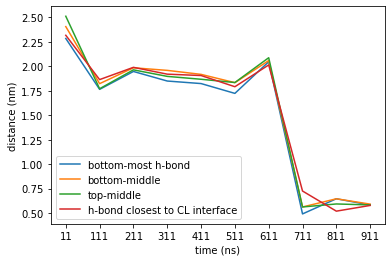

In [10]:
# Now let's look at beta-sheet hydrogen bonds across the interface that closes in trajectory 1. I've identified
# the backbone atom pairs that should be hydrogen bonded in the closed state. MDTraj gives us a variety of tools
# to select atoms or groups of atoms, here we'll use the PyMOL/VMD-like syntax.
# See http://mdtraj.org/latest/atom_selection.html for more examples
interface_pairs = [[trajlist[0].topology.select("residue 318 and name N")[0],
                    trajlist[0].topology.select("residue 619 and name O")[0]],
                   [trajlist[0].topology.select("residue 621 and name N")[0],
                    trajlist[0].topology.select("residue 316 and name O")[0]],
                   [trajlist[0].topology.select("residue 316 and name N")[0],
                    trajlist[0].topology.select("residue 621 and name O")[0]],
                   [trajlist[0].topology.select("residue 623 and name N")[0],
                    trajlist[0].topology.select("residue 314 and name O")[0]]]

# We could also see what python expression this syntax has been turned into:
print(trajlist[0].topology.select_expression("residue 318 and name N"))

print(np.array(interface_pairs))

# Calculate the distance between each pair of atoms in each frame of trajectory 1:
interface_dists = md.compute_distances(trajlist[0], interface_pairs)

# Plot all 4 distances over time:
plt.plot(interface_dists)

plt.legend(["bottom-most h-bond", "bottom-middle", "top-middle", "h-bond closest to CL interface"])

plt.xticks(np.arange(trajlist[0].n_frames), (trajlist[0].time / 1000).astype(int))
plt.xlabel("time (ns)")
plt.ylabel("distance (nm)")

# We can see that, although the interface has closed, the beta sheet hydrogen bonding across the interface has not
# yet formed by 911 ns. If we were to sample from this 1 microsecond trajectory more frequently, we would see that
# around 950 ns the hydrogen bonding forms